<a href="https://colab.research.google.com/github/OussamaLafdil/CNN-CancerDetection/blob/main/ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D
from tensorflow.keras.models import Model ,load_model
from tensorflow.keras.optimizers import Adam
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import os

##Loading the data

In [2]:
# Chemins vers les répertoires des images
augmented_data_path = '/content/drive/MyDrive/Augmented_Dataset'


class_labels = os.listdir(augmented_data_path)
print(f"Class Labels: {class_labels}")

Class Labels: ['Benign', 'Pro', 'Pre', 'Early']


In [3]:
image_paths = []
labels = []

# get the image paths and labels
for label in class_labels:
    folder_path = os.path.join(augmented_data_path, label)
    for image_file in os.listdir(folder_path):
        image_path = os.path.join(folder_path, image_file)
        image_paths.append(image_path)
        labels.append(label)

class_counts = Counter(labels)

In [4]:
# Chemin vers les images
image_arrays = []
for img_path in image_paths:
    with Image.open(img_path) as img:
        img = img.resize((224, 224))  # Redimensionner à 224x224
        image_arrays.append(np.array(img))

# Convertir en un tableau numpy
all_images = np.stack(image_arrays)
np.save('processed_images.npy', all_images)  # Sauvegarde en fichier .npy

In [5]:
# Charger les images traitées
all_images = np.load('processed_images.npy')

##Plotting Class distributions

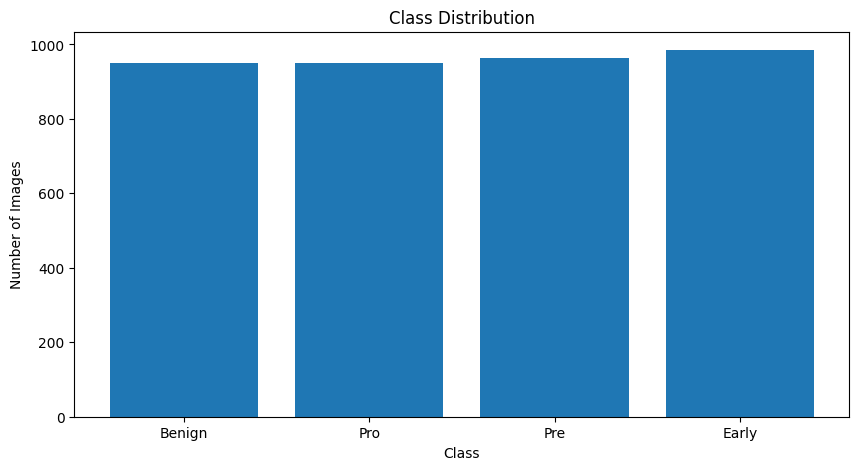

In [6]:
# plot the distribution of classes
plt.figure(figsize=(10, 5))
plt.bar(class_counts.keys(), class_counts.values())
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Number of Images')
plt.show()

##Encoding labels : one-hot encoding

In [7]:
class_names = list(set(labels))
label_to_index = {label: index for index, label in enumerate(class_names)}
labels_encoded = [label_to_index[label] for label in labels]
labels_categorical = to_categorical(labels_encoded, num_classes=len(class_names))

##Split Data into train and validation set

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(all_images, np.array(labels_categorical), test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

##Pixel Normalization

In [9]:
X_train = X_train / 255.0
X_val = X_val / 255.0
X_test = X_test / 255.0

##ResNet50 Model

In [10]:
# Création du modèle basé sur ResNet50 avec des poids préentraînés sur ImageNet
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

94765736/94765736 [==============================] - 0s 0us/step


In [11]:
# Ajout de couches personnalisées
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
output_layer = Dense(4, activation='softmax')(x)  # 4 classes : Bengin, Early, Pre, Pro

In [12]:
model = Model(inputs=base_model.input, outputs=output_layer)

 ## Déclaration du checkpoint pour sauvegarder le meilleur modèle

In [13]:
checkpoint = ModelCheckpoint(
    'best_model.keras',            # Changed the file extension to .keras
    monitor='val_accuracy',        # Metric to monitor (validation accuracy)
    verbose=1,                     # Verbose output
    save_best_only=True,           # Only save the model if it’s the best
    mode='max'                     # Save when val_accuracy is maximized
)


## Entraînement du modèle

In [14]:
# Geler toutes les couches de ResNet50
for layer in base_model.layers:
    layer.trainable = False

# Compiler le modèle pour la première phase avec les couches gelées
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Entraînement de la première phase ( 20 premières époques)
history = model.fit(
    X_train, y_train,
    epochs=30,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[checkpoint]
)

Epoch 1/30
85/85 [==============================] - ETA: 0s - loss: 1.3305 - accuracy: 0.3680
Epoch 1: val_accuracy improved from -inf to 0.51473, saving model to best_model.keras
85/85 [==============================] - 61s 676ms/step - loss: 1.3305 - accuracy: 0.3680 - val_loss: 1.1757 - val_accuracy: 0.5147
Epoch 2/30
85/85 [==============================] - ETA: 0s - loss: 1.1330 - accuracy: 0.4935
Epoch 2: val_accuracy improved from 0.51473 to 0.51646, saving model to best_model.keras
85/85 [==============================] - 55s 646ms/step - loss: 1.1330 - accuracy: 0.4935 - val_loss: 1.0559 - val_accuracy: 0.5165
Epoch 3/30
85/85 [==============================] - ETA: 0s - loss: 1.0251 - accuracy: 0.5399
Epoch 3: val_accuracy did not improve from 0.51646
85/85 [==============================] - 54s 639ms/step - loss: 1.0251 - accuracy: 0.5399 - val_loss: 1.0096 - val_accuracy: 0.4853
Epoch 4/30
85/85 [==============================] - ETA: 0s - loss: 1.0081 - accuracy: 0.5358
Ep

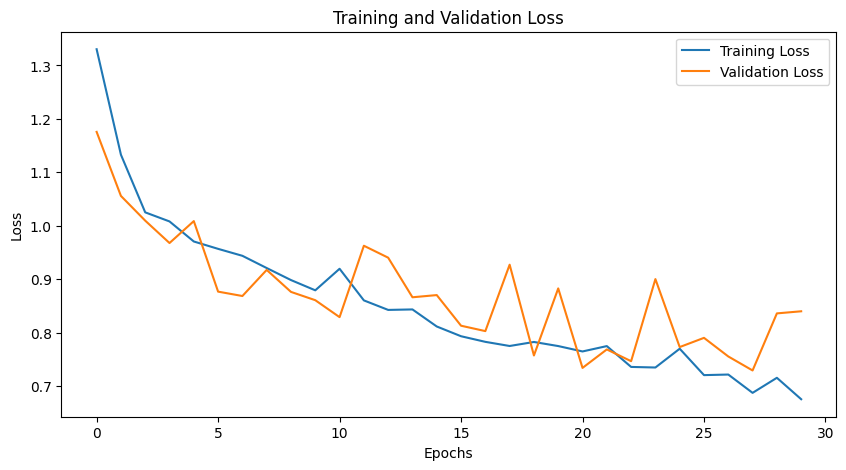

In [15]:
# Extraire les données de perte pour la phase d'entraînement
train_loss = history.history['loss']
val_loss = history.history['val_loss']


# plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [16]:
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

19/19 [==============================] - 12s 532ms/step
Classification Report:
               precision    recall  f1-score   support

         Pre       0.94      0.34      0.50       145
      Benign       0.95      0.58      0.72       142
         Pro       0.82      0.90      0.86       157
       Early       0.48      0.96      0.64       134

    accuracy                           0.69       578
   macro avg       0.80      0.69      0.68       578
weighted avg       0.80      0.69      0.68       578



In [18]:
best_model = load_model('best_model.keras')

In [19]:
# evaluate the model on validation set
val_loss, val_accuracy = best_model.evaluate(X_val, y_val)
print(f"Validation Accuracy: {val_accuracy * 100:.2f}%")

19/19 [==============================] - 11s 517ms/step - loss: 0.7340 - accuracy: 0.7158
Validation Accuracy: 71.58%


In [20]:
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)


report = classification_report(y_true, y_pred_classes, target_names=class_names)
print("Classification Report:\n", report)

19/19 [==============================] - 11s 507ms/step
Classification Report:
               precision    recall  f1-score   support

         Pre       0.75      0.59      0.66       145
      Benign       0.56      0.80      0.66       142
         Pro       0.90      0.82      0.86       157
       Early       0.71      0.62      0.66       134

    accuracy                           0.71       578
   macro avg       0.73      0.71      0.71       578
weighted avg       0.73      0.71      0.71       578



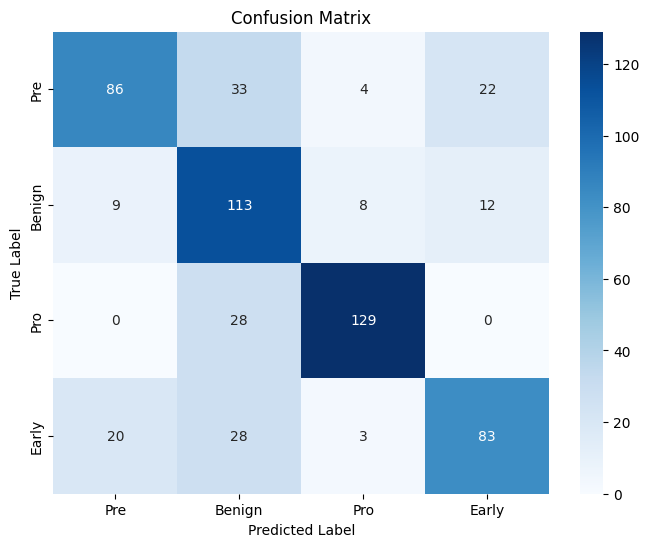

In [21]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()